# Conveyor Belt Dataset Generation

This notebook takes you through an example of how to automatically generate an image dataset for conveyor belt detection based on just a few source images.

First we need to install the dependencies for Imagemagick & Wand, which we'll use to make our image composites later

In [18]:
!pip install wand
!pip install matplotlib
!brew install freetype imagemagick@6
!export DYLD_FALLBACK_LIBRARY_PATH=/usr/local/opt/imagemagick@6/lib/


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip
Running `brew update --auto-update`...
==> Auto-updated Homebrew!
Updated 1 tap (snyk/tap).
==> Downloading https://formulae.brew.sh/api/formula.json
######################################################################## 100.0%
==> Downloading https://formulae.brew.sh/api/cask.json
######################################################################## 100.0%

You have 15 outdated formulae installed.
You can upgrade them with brew upgrade
or list them with brew outdated.

To reinstall 2.13.0, run:
  brew reinstall freetype
To reinstall 6.9.12-77, run:
  brew reinstall imagemagick@6


We need to set out a bounding box area where we want to place our objects for the image composite:

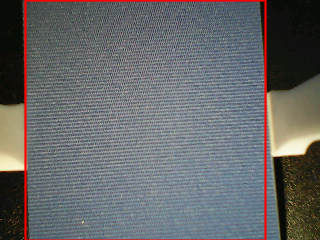

In [19]:
from wand.image import Image
from wand.drawing import Drawing
from wand.color import Color

# Load the background image
background = Image(filename ='empty.bmp')

# Define the dimensions of the background image
background_width = background.width
background_height = background.height

# Define the dimensions of the area where objects can be placed
object_area_left = 25
object_area_top = 0
object_area_width = background_width-80
object_area_height = background_height


# Draw the bounding box on the image
with Drawing() as draw:
    draw.stroke_color = Color('red')
    draw.stroke_width = 2
    draw.fill_opacity = 0
    draw.rectangle(left=object_area_left, top=object_area_top, right=object_area_left+object_area_width, bottom=object_area_top+object_area_height)
    draw(background)

# Save the image with the bounding box
background


Now we can load a test image and add in some objects. This script places up to 8 nuts onto the conveyor belt within the bounds set before, rotating them and ensuring there is no overlap.

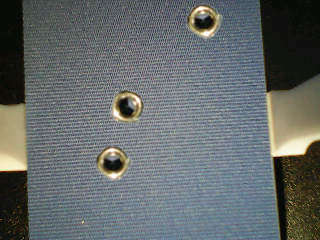

In [23]:
from wand.image import Image
import random
bg_image= Image(filename='empty.bmp')
obj_image = Image(filename='bottomcrop.bmp')
canvas = Image(width=bg_image.width, height=bg_image.height) 
objects = []
label = 'm5_nut'
# Composite the background image onto the canvas
canvas.composite(bg_image, 0, 0)
# Composite the object image onto the canvas with a random x and y position within the canvas
for i in range(random.randrange(8)):
    obj_image.rotate(random.uniform(0, 360))
    object_width = obj_image.width
    object_height = obj_image.height

    # Place the object in a random position within the defined area
    x = random.randint(object_area_left, object_area_left + object_area_width - object_width)
    y = random.randint(object_area_top, object_area_top + object_area_height - object_height)

    # Check if the object overlaps with any previously placed objects
    overlap = False
    if len(objects)>0:
        for j in range(i-1):
            if (x < objects[j]['x'] + objects[j]['width'] and x + object_width > objects[j]['x'] and
                y < objects[j]['y'] + objects[j]['height'] and y + object_height > objects[j]['y']):
                overlap = True
                break
    # If there is no overlap, place the object on the background image
    if not overlap:
        canvas.composite(obj_image, x, y)
        objects.append({'label': label, 'x': x, 'y': y, 'width': object_width, 'height': object_height})

canvas

Now we can extend this script to generate a dataset:
- First we create a list of image objects with different background frames and different angles of our object
- Next we generate our dataset by combining different objects and background images in random combination, with added motion blur and rotation.
- Finally we place the bounding box labels (the coordinates, width and height of each object placed in the image) into a bounding-box json file ready for upload to studio


In [24]:
from wand.image import Image
from wand.color import Color
import random
import json


# Define the max number of objects to place on the background image
num_objects = 8

num_images = 400
bg_images = [Image(filename ='empty.bmp'),Image(filename ='empty2.bmp'),Image(filename ='empty3.bmp'),Image(filename ='empty4.bmp'),Image(filename ='empty5.bmp'),Image(filename ='empty6.bmp'),Image(filename ='empty7.bmp')]
obj_images = [Image(filename='bottomcrop.bmp'),Image(filename='topcrop.bmp'),Image(filename='sidecrop.bmp')]

label = 'm5_nut'

bbox_json = {
    "version": 1,
    "type": "bounding-box-labels",
    "boundingBoxes": {
        
    }
}

for n in range(num_images):
    objects = []
    background = bg_images[random.randrange(len(bg_images))].clone()

    # Define the dimensions of the background image
    background_width = background.width
    background_height = background.height
    # Define the dimensions of the area where objects can be placed
    object_area_left = 25
    object_area_top = 0
    object_area_width = background_width-80
    object_area_height = background_height
    
    blur_amount = random.randrange(8)
    
    background.motion_blur(sigma=blur_amount, angle=-90)

    
    # Create a new image for each object
    for i in range(random.randrange(num_objects)):
        
        # Load the object image
        object_image = obj_images[random.randrange(len(obj_images))].clone()
        object_image.rotate(random.uniform(0, 360))

        object_width = object_image.width
        object_height = object_image.height

        object_image.resize(object_width, object_height)
        object_image.motion_blur(sigma=blur_amount, angle=-90)

        # Place the object in a random position within the defined area

        x = random.randint(object_area_left, object_area_left + object_area_width - object_width)
        y = random.randint(object_area_top, object_area_top + object_area_height - object_height)



        # Check if the object overlaps with any previously placed objects
        overlap = False
        if len(objects)>0:
            for j in range(len(objects)):
                if (x < objects[j]['x'] + objects[j]['width'] and x + object_width > objects[j]['x'] and
                    y < objects[j]['y'] + objects[j]['height'] and y + object_height > objects[j]['y']):
                    overlap = True
                    break
        # If there is no overlap, place the object on the background image
        if not overlap:
            background.composite(object_image, x, y)

            # Add the object's position and size to the list of placed objects
            objects.append({'label': label, 'x': x, 'y': y, 'width': object_width, 'height': object_height})

    # Save the new image with objects placed on top of the background
    background.save(filename=f'output/new_image{n}.png')
    bbox_json["boundingBoxes"].update({f'new_image{n}.png': objects})

with open('output/bounding_boxes.labels','w+') as file:
        json.dump(bbox_json, file, indent = 4)


Here you can see a sample of some of the auto-generated images from the dataset. These will provide a good basis for developing an object detection model

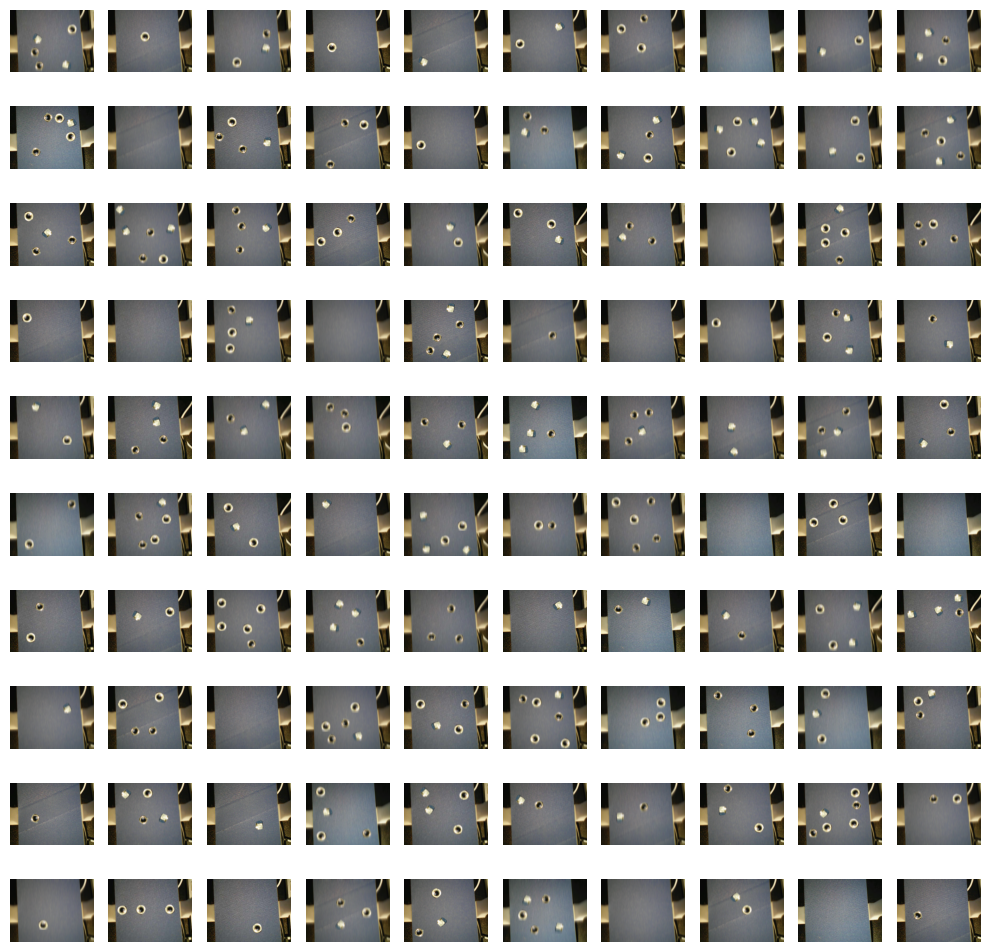

In [22]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the folder containing the images
folder_path = './output'

# Get a list of all the image files in the folder
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.png')]

# Set up the plot
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))

# Loop through each image and plot it in a grid cell
for i in range(10):
    for j in range(10):
        img = mpimg.imread(os.path.join(folder_path, image_files[i*10+j]))
        axs[i,j].imshow(img)
        axs[i,j].axis('off')

# Make the plot look clean
fig.subplots_adjust(hspace=0, wspace=0)
plt.tight_layout()
plt.show()

Finally, we must upload these files using the edge-impulse-uploader cli tool. This takes in a folder of data files and a bounding-boxes.labels file which contains labels for training.

In [26]:
!cd output && edge-impulse-uploader *

Edge Impulse uploader v1.17.0
Endpoints:
    API:         https://studio.edgeimpulse.com
    Ingestion:   https://ingestion.edgeimpulse.com

Upload configuration:
    Label:       Not set, will be infered from file name
    Category:    training
    Project:     Conveyor Belt Demo V1 (ID: 187740)

[  1/400] Failed to upload new_image109.png An item with this hash already exists (ids: 183208385)
[  2/400] Failed to upload new_image1.png An item with this hash already exists (ids: 183208401)
[  3/400] Failed to upload new_image100.png An item with this hash already exists (ids: 183208396)
[  4/400] Failed to upload new_image104.png An item with this hash already exists (ids: 183208386)
[  5/400] Failed to upload new_image115.png An item with this hash already exists (ids: 183208391)
[  6/400] Failed to upload new_image106.png An item with this hash already exists (ids: 183208392)
[  7/400] Failed to upload new_image11.png An item with this hash already exists (ids: 183208387)
[  8/400] F

[146/400] Uploading new_image228.png OK (667 ms)
[147/400] Uploading new_image236.png OK (461 ms)
[148/400] Uploading new_image229.png OK (747 ms)
[149/400] Uploading new_image237.png OK (519 ms)
[150/400] Uploading new_image23.png OK (850 ms)
[151/400] Uploading new_image24.png OK (507 ms)
[152/400] Uploading new_image235.png OK (815 ms)
[153/400] Uploading new_image238.png OK (628 ms)
[154/400] Uploading new_image245.png OK (415 ms)
[155/400] Uploading new_image222.png OK (1229 ms)
[156/400] Uploading new_image233.png OK (952 ms)
[157/400] Uploading new_image239.png OK (683 ms)
[158/400] Uploading new_image240.png OK (653 ms)
[159/400] Uploading new_image230.png OK (1099 ms)
[160/400] Uploading new_image247.png OK (487 ms)
[161/400] Uploading new_image244.png OK (557 ms)
[162/400] Uploading new_image246.png OK (553 ms)
[163/400] Uploading new_image25.png OK (368 ms)
[164/400] Uploading new_image248.png OK (514 ms)
[165/400] Uploading new_image241.png OK (778 ms)
[166/400] Uploading n

[314/400] Uploading new_image384.png OK (469 ms)
[315/400] Uploading new_image383.png OK (542 ms)
[316/400] Uploading new_image377.png OK (877 ms)
[317/400] Uploading new_image392.png OK (372 ms)
[318/400] Uploading new_image390.png OK (440 ms)
[319/400] Uploading new_image391.png OK (430 ms)
[320/400] Uploading new_image386.png OK (572 ms)
[321/400] Uploading new_image378.png OK (1005 ms)
[322/400] Uploading new_image381.png OK (925 ms)
[323/400] Uploading new_image385.png OK (712 ms)
[324/400] Uploading new_image395.png OK (448 ms)
[325/400] Uploading new_image387.png OK (836 ms)
[326/400] Uploading new_image399.png OK (463 ms)
[327/400] Uploading new_image4.png OK (505 ms)
[328/400] Uploading new_image42.png OK (406 ms)
[329/400] Uploading new_image389.png OK (919 ms)
[330/400] Uploading new_image41.png OK (557 ms)
[331/400] Uploading new_image394.png OK (825 ms)
[332/400] Uploading new_image396.png OK (862 ms)
[333/400] Uploading new_image5.png OK (343 ms)
[334/400] Uploading new_i

# OpenMV Object Counting Script
Once the model is trained we can use this script in OpenMV to run our model on an edge device and count objects that pass on the conveyor belt:

In [ ]:
# Edge Impulse - OpenMV Object Detection Example

import sensor, image, time, os, tf, math, uos, gc

sensor.reset()                         # Reset and initialize the sensor.
sensor.set_pixformat(sensor.RGB565)    # Set pixel format to RGB565 (or GRAYSCALE)
sensor.set_framesize(sensor.QVGA)      # Set frame size to QVGA (320x240)
sensor.set_windowing((240, 240))       # Set 240x240 window.
sensor.skip_frames(time=2000)          # Let the camera adjust.

net = None
labels = None
min_confidence = 0.5

try:
    # load the model, alloc the model file on the heap if we have at least 64K free after loading
    net = tf.load("trained.tflite", load_to_fb=uos.stat('trained.tflite')[6] > (gc.mem_free() - (64*1024)))
except Exception as e:
    raise Exception('Failed to load "trained.tflite", did you copy the .tflite and labels.txt file onto the mass-storage device? (' + str(e) + ')')


try:
    labels = [line.rstrip('\n') for line in open("labels.txt")]
except Exception as e:
    raise Exception('Failed to load "labels.txt", did you copy the .tflite and labels.txt file onto the mass-storage device? (' + str(e) + ')')

colors = [ # Add more colors if you are detecting more than 7 types of classes at once.
    (255,   0,   0),
    (  0, 255,   0),
    (255, 255,   0),
    (  0,   0, 255),
    (255,   0, 255),
    (  0, 255, 255),
    (255, 255, 255),
]

clock = time.clock()



# Define the top of the image and the number of columns
TOP_Y = 100
NUM_COLS = 5
COL_WIDTH = int(sensor.width() / NUM_COLS)
# Define the factor of the width/height which determines the threshold
# for detection of the object's movement between frames:
DETECT_FACTOR = 1.5

# Initialize variables
count = [0] * NUM_COLS
previous_blobs = [[] for _ in range(NUM_COLS)]

while(True):
    clock.tick()

    img = sensor.snapshot()

    # detect() returns all objects found in the image (splitted out per class already)
    # we skip class index 0, as that is the background, and then draw circles of the center
    # of our objects

    # Initialize list of current blobs
    current_blobs = [[] for _ in range(NUM_COLS)]

    for i, detection_list in enumerate(net.detect(img, thresholds=[(math.ceil(min_confidence * 255), 255)])):
        if (i == 0): continue # background class
        if (len(detection_list) == 0): continue # no detections for this class?

        print("********** %s **********" % labels[i])
        for d in detection_list:
            [x, y, w, h] = d.rect()
            center_x = math.floor(x + (w / 2))
            center_y = math.floor(y + (h / 2))
            print('x %d\ty %d' % (center_x, center_y))
            img.draw_circle((center_x, center_y, 12), color=colors[i], thickness=2)

            # Check which column the blob is in
            col = int(x / COL_WIDTH)
            # Check if blob is within DETECT_FACTOR*h of a blob detected in the previous frame and treat as the same object
            for blob in previous_blobs[col]:
                if abs(x - blob[0]) < DETECT_FACTOR * (w + blob[2]) and abs(y - blob[1]) < DETECT_FACTOR * (h + blob[3]):
                # Check this blob has "moved" across the Y threshold
                    if blob[1] >= TOP_Y and y < TOP_Y:
                        # Increment count for this column if blob has left the top of the image
                        count[col] += 1
             # Add current blob to list
            current_blobs[col].append((x, y, w, h))

    print(clock.fps(), "fps", end="\n\n")

    # Update previous blobs
    previous_blobs = current_blobs

    # Print count for each column
    print("Count: ", count)
    img.draw_string(5, 2, "Object count: {}".format(sum(count)), color=(255, 255, 0))
    img.draw_string(5, 230, "FPS: {}".format(round(clock.fps())), color=(0, 0, 0))

